# Análisis exploratorio de datos

In [1]:
import pandas as pd                         # Manejo de datos
import numpy as np                          # Manejo de datos
import matplotlib.pyplot as plt             # Graficos
import seaborn as sns                       # Graficos
import datetime                             # Formato de fechas
from wordcloud import WordCloud             # Word cloud
from nltk.corpus import stopwords           # Eliminar stopwords
from flydenity import Parser                # Obtener información de los vuelos
from geopy.geocoders import Nominatim       # Obtener latitud y longitud
from ast import literal_eval as make_tuple  # Tuplas en str a tuple

# Graficar con latitud y longitud
import geopandas as gpd                     
from geopandas import GeoDataFrame
from shapely.geometry import Point

# Temas para graficar
plt.style.use('ggplot')
sns.set_style("darkgrid")

Cargamos los datos y vemos las columnas y la cantidad de datos por columna.

In [2]:
df = pd.read_csv('dataset/AccidentesAviones.csv')
df.head()

,Unnamed: 0,fecha,HORA declarada,Ruta,OperadOR,flight_no,route,ac_type,registration,cn_ln,all_aboard,PASAJEROS A BORDO,crew_aboard,cantidad de fallecidos,passenger_fatalities,crew_fatalities,ground,summary
0,0,"September 17, 1908",1718,"Fort Myer, Virginia",Military - U.S. Army,?,Demonstration,Wright Flyer III,?,1,2,1,1,1,1,0,0,"During a demonstration flight, a U.S. Army fly..."
1,1,"September 07, 1909",?,"Juvisy-sur-Orge, France",?,?,Air show,Wright Byplane,SC1,?,1,0,1,1,0,0,0,Eugene Lefebvre was the first pilot to ever be...
2,2,"July 12, 1912",0630,"Atlantic City, New Jersey",Military - U.S. Navy,?,Test flight,Dirigible,?,?,5,0,5,5,0,5,0,First U.S. dirigible Akron exploded just offsh...
3,3,"August 06, 1913",?,"Victoria, British Columbia, Canada",Private,?,?,Curtiss seaplane,?,?,1,0,1,1,0,1,0,The first fatal airplane accident in Canada oc...
4,4,"September 09, 1913",1830,Over the North Sea,Military - German Navy,?,?,Zeppelin L-1 (airship),?,?,20,?,?,14,?,?,0,The airship flew into a thunderstorm and encou...


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5008 non-null   int64 
 1   fecha                   5008 non-null   object
 2   HORA declarada          5008 non-null   object
 3   Ruta                    5008 non-null   object
 4   OperadOR                5008 non-null   object
 5   flight_no               5008 non-null   object
 6   route                   5008 non-null   object
 7   ac_type                 5008 non-null   object
 8   registration            5008 non-null   object
 9   cn_ln                   5008 non-null   object
 10  all_aboard              5008 non-null   object
 11  PASAJEROS A BORDO       5008 non-null   object
 12  crew_aboard             5008 non-null   object
 13  cantidad de fallecidos  5008 non-null   object
 14  passenger_fatalities    5008 non-null   object
 15  crew

Los faltantes en este dataset están denotados por '?'. Para ver el número de faltantes, sustituimos los '?' por `None`.

In [4]:
df.replace({'?':None}, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5008 non-null   int64 
 1   fecha                   5008 non-null   object
 2   HORA declarada          3504 non-null   object
 3   Ruta                    5003 non-null   object
 4   OperadOR                4998 non-null   object
 5   flight_no               1326 non-null   object
 6   route                   4246 non-null   object
 7   ac_type                 4995 non-null   object
 8   registration            4736 non-null   object
 9   cn_ln                   4341 non-null   object
 10  all_aboard              4991 non-null   object
 11  PASAJEROS A BORDO       4787 non-null   object
 12  crew_aboard             4789 non-null   object
 13  cantidad de fallecidos  5000 non-null   object
 14  passenger_fatalities    4773 non-null   object
 15  crew

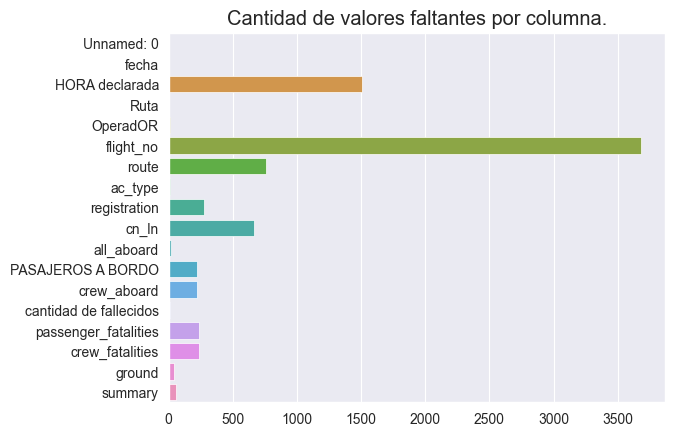

In [5]:
# Ploteamos el numero de faltantes por columna
sns.barplot(x = df.isnull().sum().values, y = df.columns)
plt.title('Cantidad de valores faltantes por columna.');

Cambiamos el nombre de las columnas para manejar más facilmente

In [6]:
df.rename(columns = {'Unnamed: 0':'id','fecha':'date', 'HORA declarada':'time', 'Ruta':'location', 'OperadOR':'operator', 'ac_type':'plane_type',
       'PASAJEROS A BORDO':'passengers', 'all_aboard': 'aboard', 'crew_aboard':'crew', 'cantidad de fallecidos':'fatalities'},inplace=True)

Cambiamos los formatos de las columnas para poder graficar

In [7]:
df.columns

Index(['id', 'date', 'time', 'location', 'operator', 'flight_no', 'route',
       'plane_type', 'registration', 'cn_ln', 'aboard', 'passengers', 'crew',
       'fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground',
       'summary'],
      dtype='object')

In [8]:
# Las fechas a formato datetime
df.date = pd.to_datetime(df.date, infer_datetime_format=True)

In [9]:
# Eliminamos caracteres no numéricos de time
df.time = df.time.str.replace(r'\D','', regex=True).str.strip()

In [10]:
def to_time(x):
    '''Cambia horas militares a horas 24 h'''
    # Si el valor no es nulo
    if x:
        # revisamos si tiene 3 caracteres
        if len(x) == 3:
            try: 
                # intentamos convertirlo en fecha agregando un 0 a la izq
                return datetime.datetime.strptime(x.zfill(4),'%H%M').strftime('%H:%M')
            except: 
                # si no podemos, le agregamos un 0 a la derecha
                return datetime.datetime.strptime(x.ljust(4, '0'),'%H%M').strftime('%H:%M')
        else:
            # si tiene 4 caracteres, lo convertimos en fecha
            return datetime.datetime.strptime(x,'%H%M').strftime('%H:%M')     
    # Si el valor es nulo se queda nulo
    else:
        return None 

In [11]:
# Las horas a formato 00:00
df.time = df.time.apply(to_time)
df.time.head()

0    17:18
1     None
2    06:30
3     None
4    18:30
Name: time, dtype: object

Ahora formateamos strings

In [12]:
def format_str(df, column):
    '''Formatear strings colocando iniciales en mayuscula 
    y eliminando espacios en blanco a izq y der'''
    return df[column].astype(str).str.strip().str.title()

In [13]:
# Loop para formatear todos los strings
columns = ['location', 'operator', 'route', 'plane_type', 'summary']
for column in columns:
    df[column] = format_str(df,column)

# Revisamos que se hayan formateado
df.head(3)

,id,date,time,location,operator,flight_no,route,plane_type,registration,cn_ln,aboard,passengers,crew,fatalities,passenger_fatalities,crew_fatalities,ground,summary
0,0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,None,Demonstration,Wright Flyer Iii,None,1,2,1,1,1,1,0,0,"During A Demonstration Flight, A U.S. Army Fly..."
1,1,1909-09-07,None,"Juvisy-Sur-Orge, France",None,None,Air Show,Wright Byplane,SC1,None,1,0,1,1,0,0,0,Eugene Lefebvre Was The First Pilot To Ever Be...
2,2,1912-07-12,06:30,"Atlantic City, New Jersey",Military - U.S. Navy,None,Test Flight,Dirigible,None,None,5,0,5,5,0,5,0,First U.S. Dirigible Akron Exploded Just Offsh...


A las variables no numéricas que no mezcla de caracteres alfanuméricos les eliminamos los espacios en blanco:

In [14]:
# códigos
df.flight_no.replace(' ','', inplace=True)
df.registration.replace(' ','', inplace=True)
df.cn_ln.replace(' ','', inplace=True)

Ahora, definimos una función para formatear columnas con valores numéricos y hacemos un loop para formatearlas

In [15]:
def format_int(df, column):
    '''Formatea columnas numéricas con valores nulos'''
    
    S = df[column].fillna(value=np.nan)
    # Al valor nulo se le asigna un numero que no se encuentre en la columna
    # y se convierte la columna en int
    S = S.fillna(9999).astype(int)
    # se remplazan nuevamente los nulos
    S.replace(9999, np.nan, inplace=True)
    
    return S

In [16]:
# loop para formatear columnas numéricas
columns = ['aboard', 'passengers', 'crew', 'fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground']
for column in columns:
    df[column] = format_int(df,column)

df.head(3)

,id,date,time,location,operator,flight_no,route,plane_type,registration,cn_ln,aboard,passengers,crew,fatalities,passenger_fatalities,crew_fatalities,ground,summary
0,0,1908-09-17,17:18,"Fort Myer, Virginia",Military - U.S. Army,None,Demonstration,Wright Flyer Iii,None,1,2.0,1.0,1.0,1.0,1.0,0.0,0.0,"During A Demonstration Flight, A U.S. Army Fly..."
1,1,1909-09-07,None,"Juvisy-Sur-Orge, France",None,None,Air Show,Wright Byplane,SC1,None,1.0,0.0,1.0,1.0,0.0,0.0,0.0,Eugene Lefebvre Was The First Pilot To Ever Be...
2,2,1912-07-12,06:30,"Atlantic City, New Jersey",Military - U.S. Navy,None,Test Flight,Dirigible,None,None,5.0,0.0,5.0,5.0,0.0,5.0,0.0,First U.S. Dirigible Akron Exploded Just Offsh...


## Plots
Vamos a visualizar brevemente los datos. Vemos las correlaciones y las distribuciones.

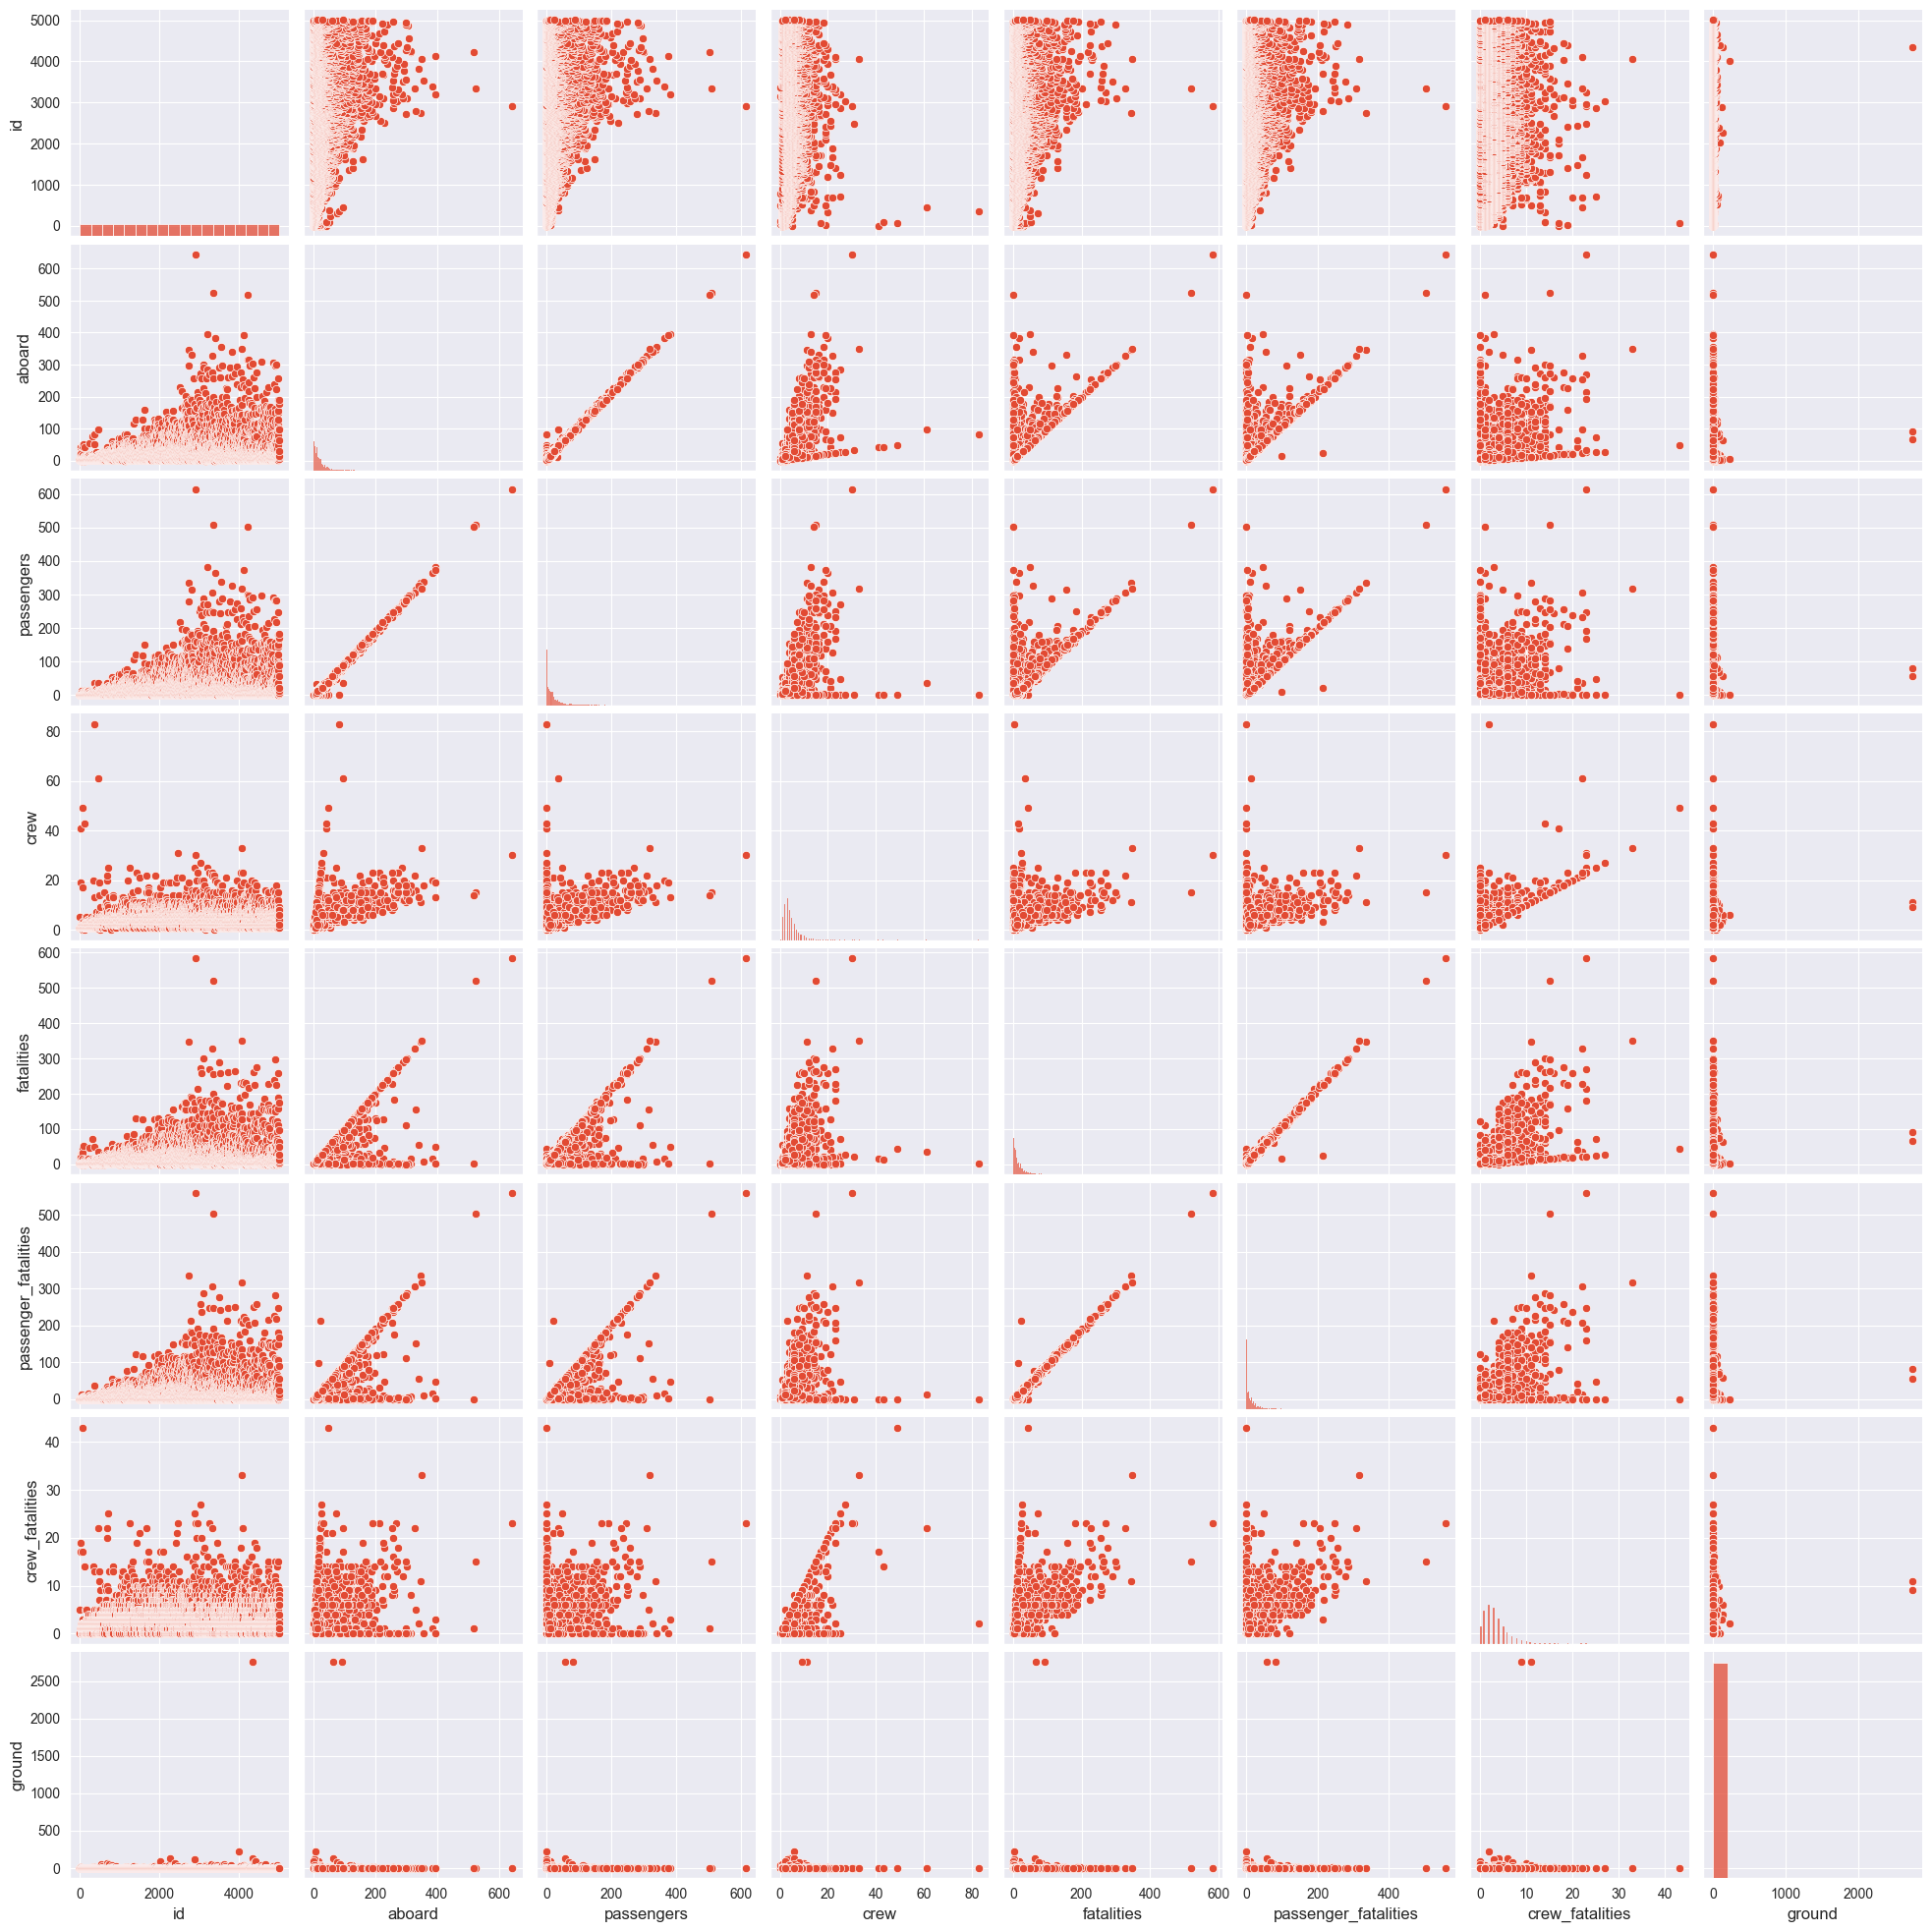

In [17]:
sns.pairplot(data=df);

Ahora que esta formateado, revisamos los valores únicos:

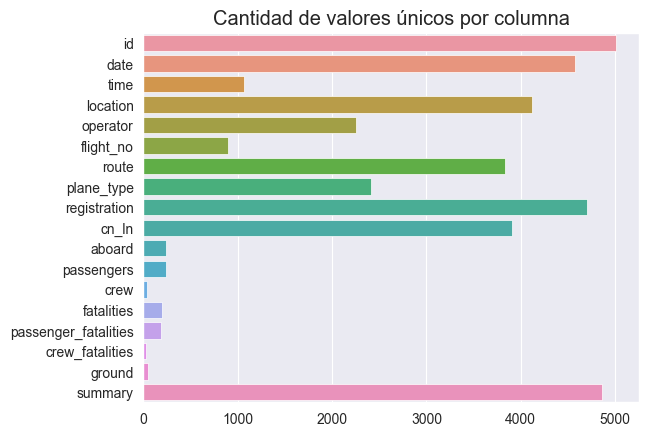

In [18]:
sns.barplot(x = df.nunique().values, y = df.columns)
plt.title('Cantidad de valores únicos por columna');

Y el mapa de correlaciones

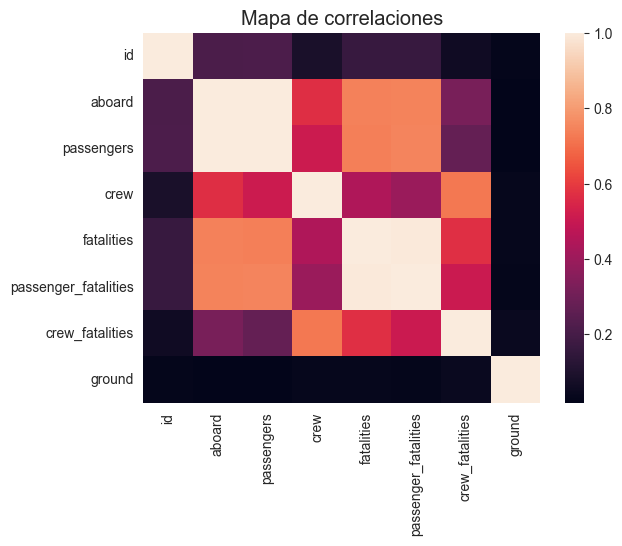

In [19]:
sns.heatmap(df.corr(numeric_only=True))
plt.title('Mapa de correlaciones');

Podemos hacer un word cloud de summary.

In [20]:
stop = stopwords.words('english')
S = df.summary.str.lower().apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
S['count'] = S.str.split(expand=True).stack().value_counts()
S = S['count'].reset_index()
S.rename(columns = {0:'count'}, inplace=True)

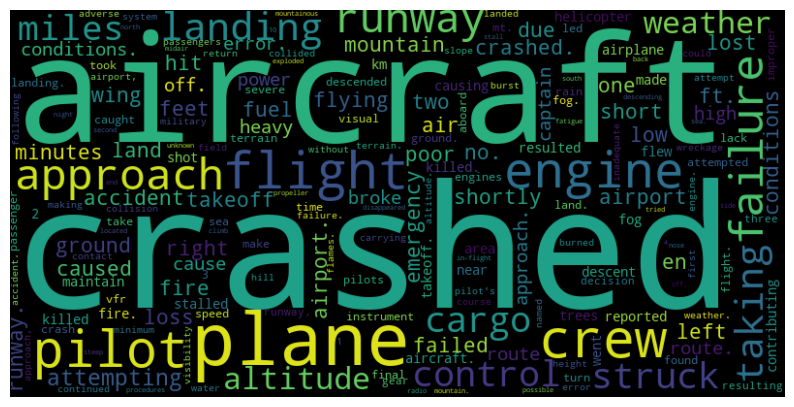

In [21]:
# hacemos un word cloud 
data = S.set_index('index').to_dict()['count']

wc = WordCloud(width=800, height=400, max_words=200).generate_from_frequencies(data)

plt.figure(figsize=(10, 10))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

Revisemos los diez valores con más accidentes en cada columna con strings:

In [22]:
def ten_values(df, column, axis=None):
    '''Plot de los 10 valores principales agrupados por cuenta'''

    plane = df.pivot_table(index = [column], aggfunc ='size').sort_values(ascending=False)
    
    # Opcion para ejes
    if axis:
        sns.barplot(ax=axis, x=plane.values[:10], y=plane.index[:10])
    else:
        sns.barplot(x=plane.values[:10], y=plane.index[:10])
        plt.title('10 {} con más accidentes'.format(column))
        plt.show()
        plt.close()

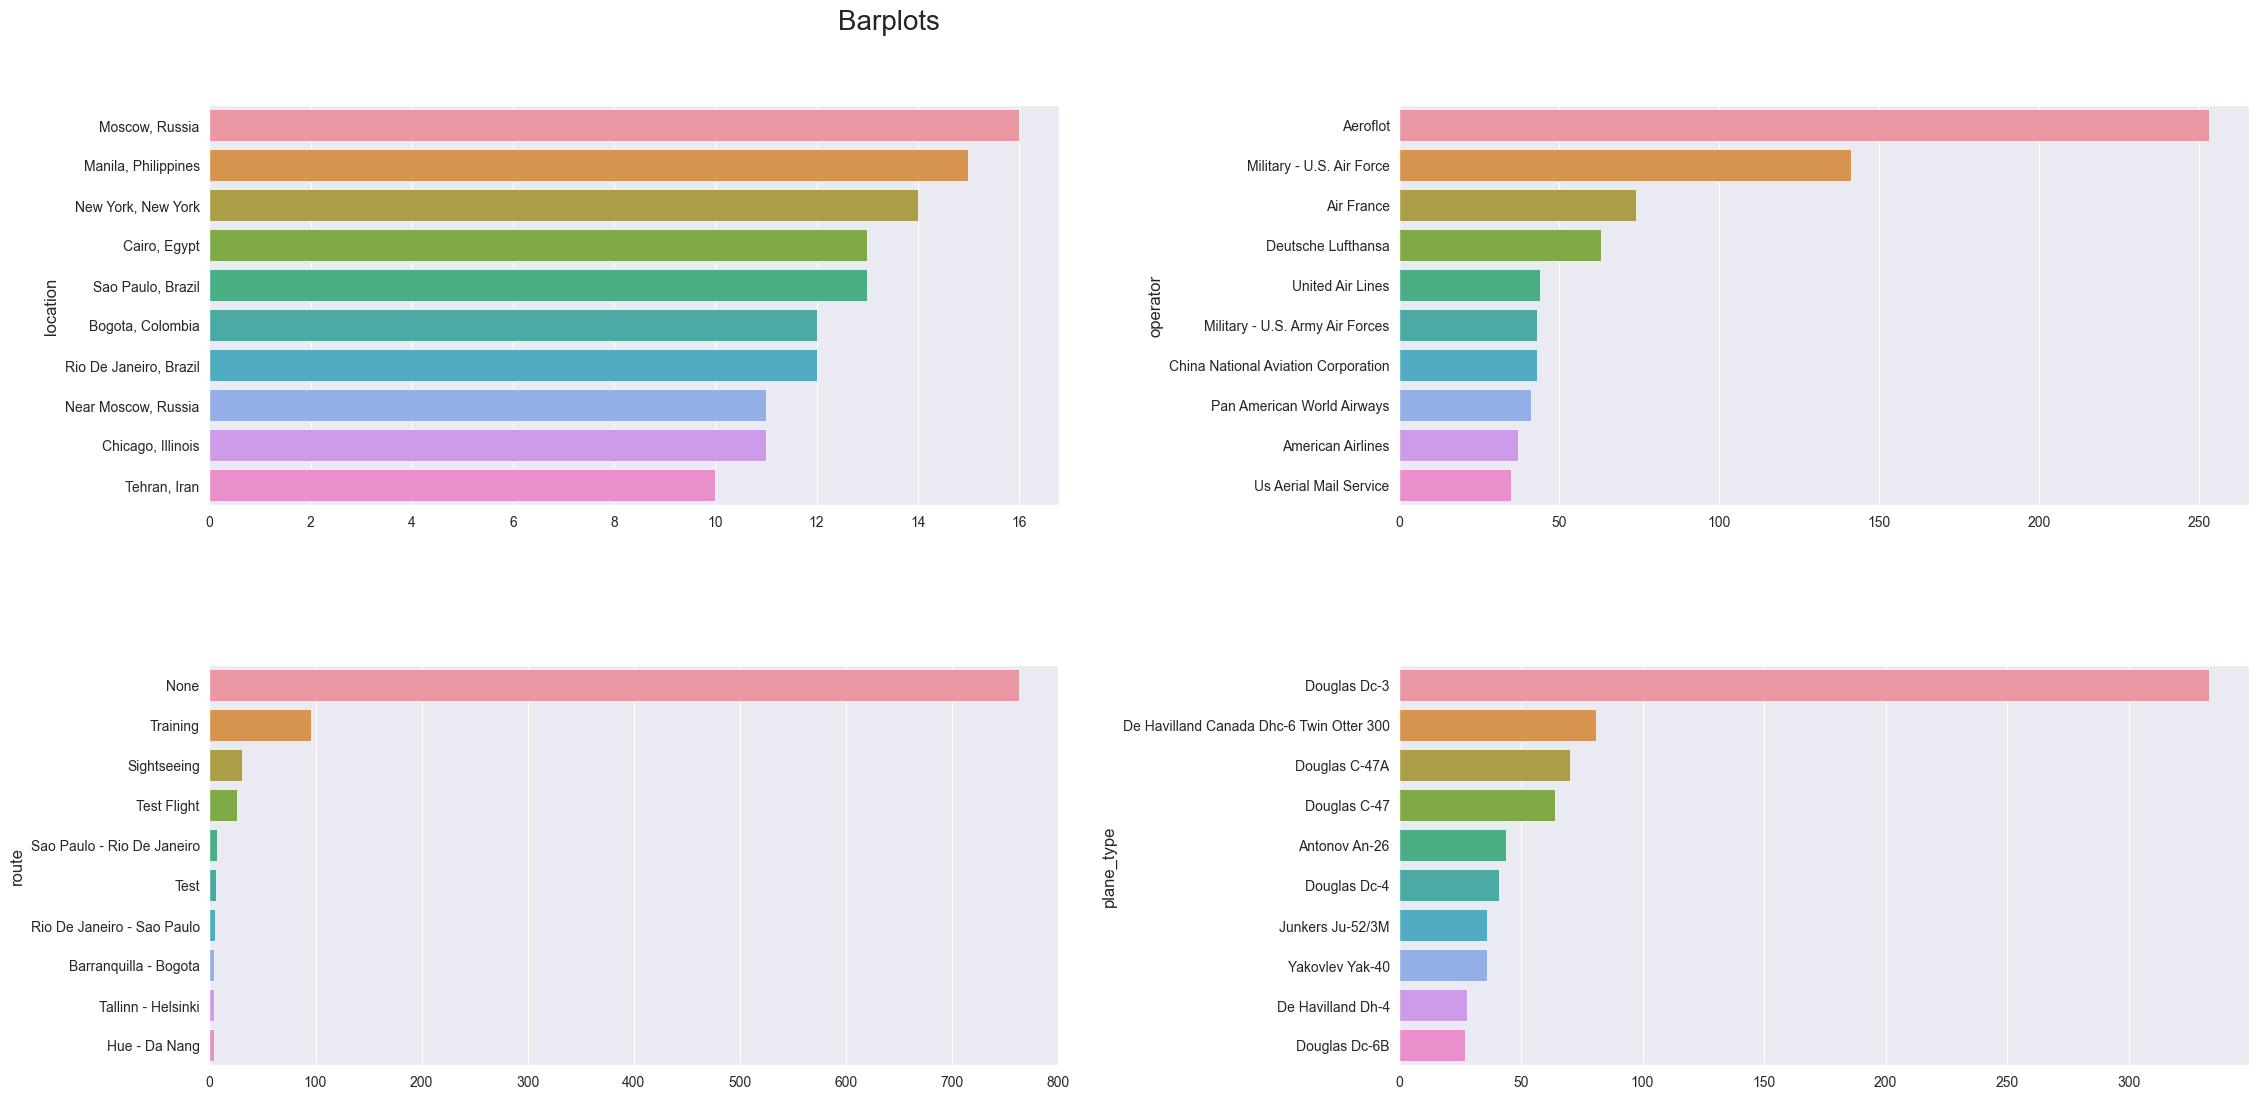

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(17,12))
columns = ['location', 'operator', 'route', 'plane_type']
fig.suptitle('Barplots', fontsize=20)
nvar=0

for ii in range(2):
    for jj in range(2):
        ten_values(df, columns[nvar], axis=axes[ii, jj])
        nvar+=1

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=1.3,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

Podemos estudiar también el número de accidentes por año:

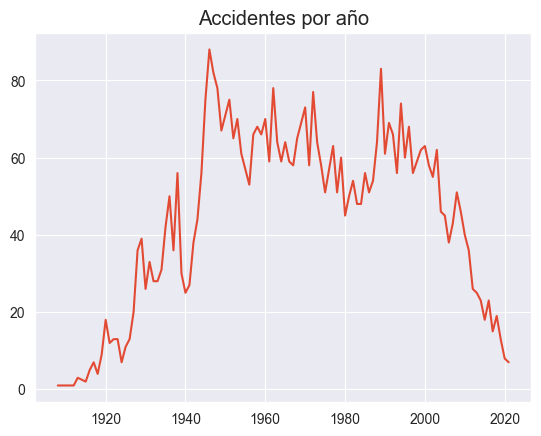

In [24]:
yearly = df.date.dt.year.value_counts()

sns.lineplot(x=yearly.index, y=yearly.values)
plt.title('Accidentes por año');

In [25]:
# Los valores faltantes no-numericos se remplazan con strings que indican falta de dato
df.time.fillna('Sin dato', inplace=True)
df.flight_no.fillna('Sin dato', inplace=True)
df.registration.fillna('Sin dato', inplace=True)
df.cn_ln.fillna('Sin dato', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   id                    5008 non-null   int64         
 1   date                  5008 non-null   datetime64[ns]
 2   time                  5008 non-null   object        
 3   location              5008 non-null   object        
 4   operator              5008 non-null   object        
 5   flight_no             5008 non-null   object        
 6   route                 5008 non-null   object        
 7   plane_type            5008 non-null   object        
 8   registration          5008 non-null   object        
 9   cn_ln                 5008 non-null   object        
 10  aboard                4991 non-null   float64       
 11  passengers            4787 non-null   float64       
 12  crew                  4789 non-null   float64       
 13  fatalities        

## Creación de variables
A partir de las variables en el dataset podemos obtener otras variables útiles para el análisis. De `location` podemos obtener el pais o lugar del accidente.

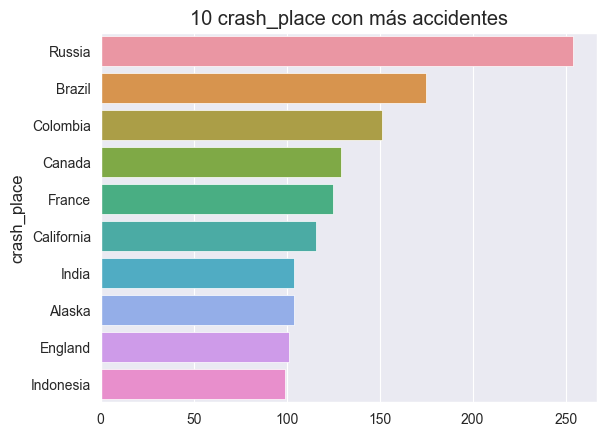

In [26]:
df['crash_place'] = df.location.str.replace(',',' , ').str.split(',').str[-1].str.strip()
ten_values(df, 'crash_place')

O los sobrevivientes de cada accidente

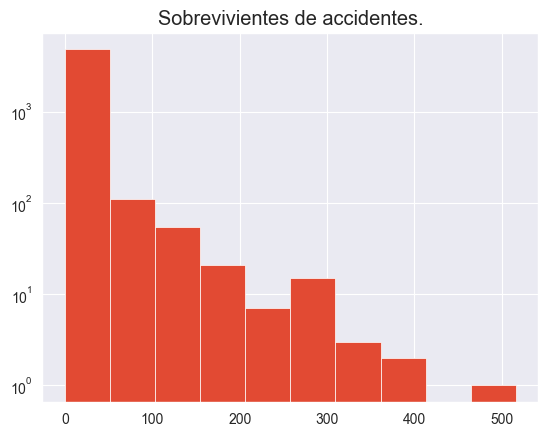

In [27]:
df['survivors'] = df.aboard - df.fatalities
df.survivors.hist(log=True)
plt.title('Sobrevivientes de accidentes.');

Tambien el día de la semana y el mes del año:

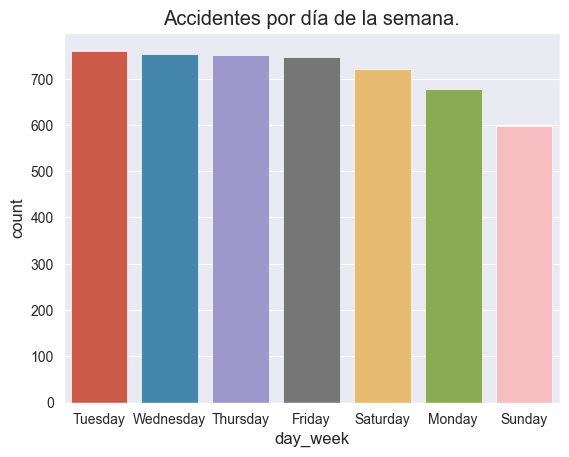

In [28]:
df['day_week'] = pd.DatetimeIndex(df['date']).day_name()
sns.countplot(x=df.day_week,order = df.day_week.value_counts().index)
plt.title('Accidentes por día de la semana.');


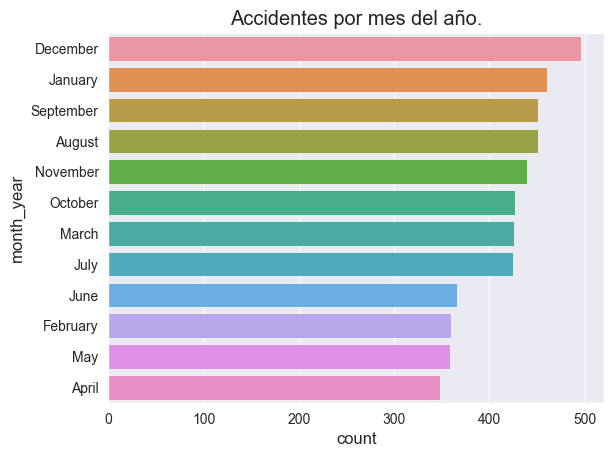

In [29]:
df['month_year'] = pd.DatetimeIndex(df['date']).month_name()
sns.countplot(y=df.month_year, order= df.month_year.value_counts().index)
plt.title('Accidentes por mes del año.');

Vamos a utilizar un api (https://github.com/Collen-Roller/flydenity) para obtener datos del pais de salida del avión a través del código de registo.

In [30]:
parser = Parser()
lista = []
for nrow in range(df.shape[0]):
    # obtenemos el codigo de registro para la fila
    code = df.registration[nrow]
    # lo ponemos en un diccionario
    d = {'plane_id': code}
    info = parser.parse(code)
    if info:
        # hacemos update del diccionario con los datos obtenidos
        d.update(info)
        lista.append(d)
    else:
        continue

# Hacemos un dataframe con los diccionarios
df_aviones = pd.DataFrame(lista)
df_aviones.head()

,plane_id,nation,description,iso2,iso3
0,SC1,Sweden,general,SE,SWE
1,G-EAHG,United Kingdom,general,GB,GBR
2,G-EAHF,United Kingdom,general,GB,GBR
3,204,Guernsey,general,GG,GGY
4,G-EALW,United Kingdom,general,GB,GBR


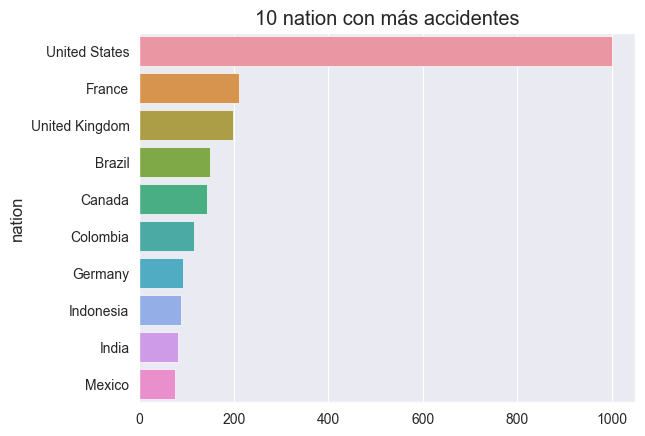

In [31]:
# graficamos los paises de salida con mas accidentes
ten_values(df_aviones, 'nation')

Utilizamos otro api (https://github.com/geopy/geopy) para obtener las coordenadas de los lugares, utilizando `location`

In [32]:
# El codigo en esta celda tardó 1 h
# se guardó el resultado para poder volver a correr el notebook
geolocator = Nominatim(user_agent="henry")

def get_coordinates(x):
    try:
        location = geolocator.geocode(x)
        return (location.latitude,location.longitude)
    except:
        return None

#df['temp_coor'] = df.location.apply(get_coordinates)
#df.temp_coor.to_csv('dataset/coordenadas.csv', index=False)

In [33]:
# Las tuplas se guardaron como string
df_temp = pd.read_csv('dataset/coordenadas.csv')
df = pd.concat([df, df_temp], axis=1)

def str_to_tuple(x):
    '''Convertir strings de tuplas en tuplas'''
    try:
        return make_tuple(x)
    except: 
        return np.nan

df.temp_coor = df.temp_coor.apply(str_to_tuple)

In [34]:
# separamos en latitud y longitud
df[['latitude', 'longitude']] = pd.DataFrame(df.temp_coor.tolist(), index=df.index)

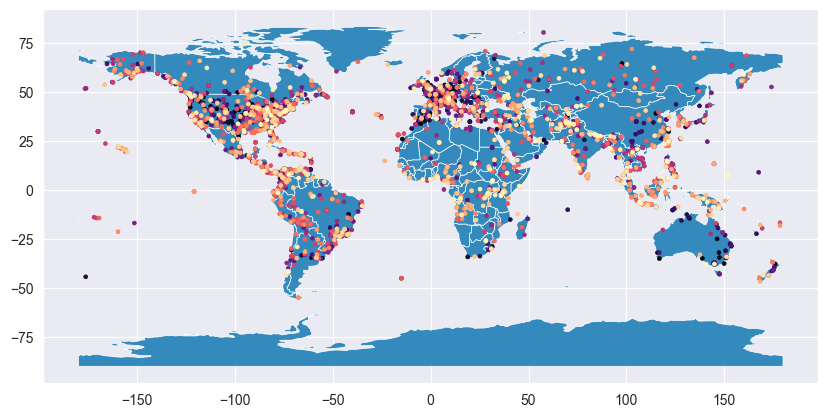

In [35]:
# Graficamos los puntos obtenidos
dfpos = df.loc[(df.latitude.notnull())&(df.longitude.notnull())].copy()

geometry = [Point(xy) for xy in zip(dfpos['longitude'], dfpos['latitude'])]
gdf = GeoDataFrame(dfpos, geometry=geometry)    

# Ploteamos el mapa
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(figsize=(10, 6)), marker='o', cmap='magma', markersize=8);

Agregamos una columna de 0 y 1 si los accidentes estan relacionados a algo militar:

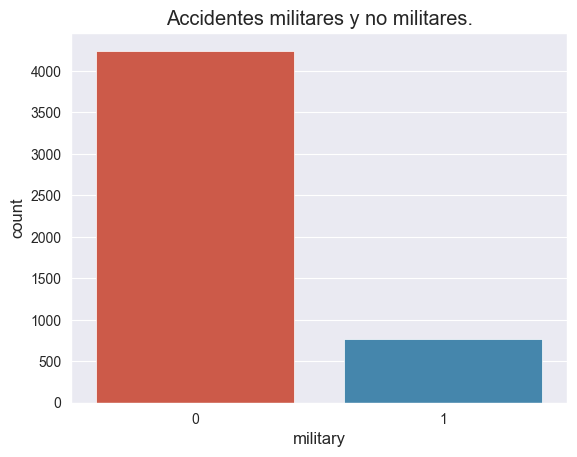

In [36]:
df["military"] = df.operator.str.lower().str.contains("military", regex=False)
# convertimos en int 
# 1 significa militar
df.military = df.military.astype(int)
sns.countplot(data=df, x='military')
plt.title('Accidentes militares y no militares.');

Buscamos las causas principales de los accidentes en el summary

In [37]:
def add_list(x, val):
    '''Agregar valores a una lista en una celda'''
    if x:
        if val in x:
            pass
        else:
            x.append(val)
    else:
        x = [val]
    return x

def find_cause(df, type_cause):
    ''''Hallar palabras en una columna y agregar un key y la palabra hallada
    a otra columna'''
    error = type_cause[0]
    words = type_cause[1]

    for word in words:
        df.loc[df.summary.str.lower().str.contains(word, na=False),'error_type'] = df.loc[df.summary.str.lower().str.contains(word, na=False)]['error_type'].apply(lambda x: add_list(x,error))
        df.loc[df.summary.str.lower().str.contains(word, na=False),'key_word'] = df.loc[df.summary.str.lower().str.contains(word, na=False)]['key_word'].apply(lambda x: add_list(x,word))
        

In [38]:
# Agrupamos algunas causas de accidentes
human = ('human_error',['pilot', 'maneuvers', 'air traffic', 'controler'])
mechanical = ('mechanical_issues',['mechanical', 'engine', 'maintenance', 'fuel'])
weather = ('weather',['weather', 'storm', 'rain', 'thunderstorm'])
takeoff = ('takeoff',['taxi','takeoff'])
landing = ('landing',['descent','landing'])
water_crash = ('water_crash',['sea','water','ditching','water crash'])
terrorism = ('terrorism',['terrorism','hijacking', 'hijack','skyjacking', 'plane hijacking', 'plane jacking', 'air robbery', 'air piracy'])

errors = [human, mechanical, weather, takeoff, landing, water_crash, terrorism]
df = df.copy()
df['error_type'] = None
df['key_word'] = None

# Agregamos cada error
for error in errors:
    find_cause(df, error)

In [39]:
# no se pueden revisar unicos en columnas de listas
# creamos una funcion
unique = []
def check_unique(x):
    if x in unique: pass
    else: unique.append(x)
    return x

In [40]:
df.error_type.apply(check_unique);
unique[:5]

[None,
 ['human_error'],
 ['weather'],
 ['weather', 'water_crash'],
 ['mechanical_issues', 'water_crash']]

Agregamos el tipo de error como variable dummy

In [41]:
df[['human_error', 'landing', 'mechanical_issues', 'takeoff', 'terrorism', 'water_crash', 'weather']] = df['error_type'].str.join('|').str.get_dummies()

Agregamos un dataset del numero de pasajeros por año (https://data.worldbank.org/indicator/IS.AIR.DPRT?end=2016&start=1970&view=chart), para poder ver la proporción de accidentes 

In [42]:
df_vuelos = pd.read_csv('dataset/API_IS.AIR.DPRT_DS2_en_csv_v2_4536741.csv', skiprows=3)
df_vuelos.head(3)

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,Unnamed: 66
0,Aruba,ABW,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2132.0,2276.000000,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,548834.772,534810.303494,556341.0,562927.0,630147.0,705127.484622,717795.3,298383.68085,NaN,NaN
2,Afghanistan,AFG,"Air transport, registered carrier departures w...",IS.AIR.DPRT,NaN,NaN,NaN,NaN,NaN,NaN,...,21696.000,25920.000000,23532.0,22770.0,24207.0,10454.000000,7334.0,4635.71400,NaN,NaN


Limpiamos un poco

In [43]:
df_vuelos.drop(['Indicator Name','Indicator Code', 'Unnamed: 66'], axis='columns', inplace=True)
df_vuelos = df_vuelos.fillna(0)
df_vuelos.head(3)

,Country Name,Country Code,1960,1961,1962,1963,1964,1965,1966,1967,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021
0,Aruba,ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000,0.000000,0.0,0.0,2132.0,2276.000000,0.0,0.00000,0.0
1,Africa Eastern and Southern,AFE,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,514462.289437,548834.772,534810.303494,556341.0,562927.0,630147.0,705127.484622,717795.3,298383.68085,0.0
2,Afghanistan,AFG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17775.000000,21696.000,25920.000000,23532.0,22770.0,24207.0,10454.000000,7334.0,4635.71400,0.0


In [44]:
df_passengers = df_vuelos.drop(['Country Name','Country Code'], axis='columns').sum()
df_passengers = df_passengers[df_passengers != 0]
df_passengers = df_passengers.rename('sum')
df_passengers.index.name = 'year'
df_passengers.head()

year
1970    57172800.0
1971    57470500.0
1972    48246800.0
1973    59097600.0
1974    64820200.0
Name: sum, dtype: float64

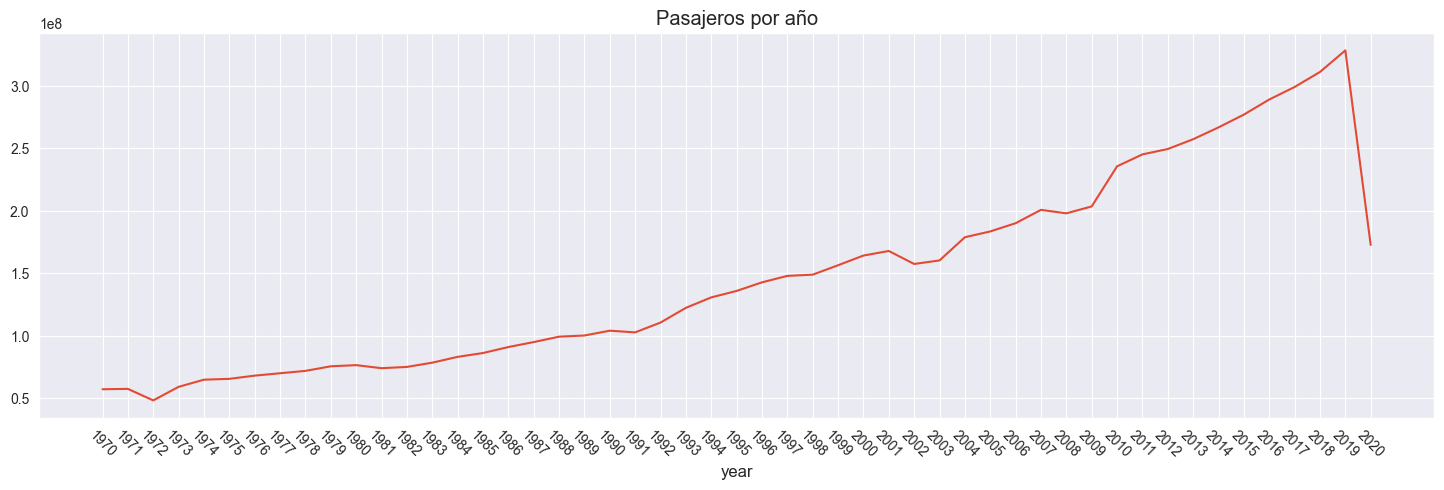

In [45]:
plt.figure(figsize=(18,5))
sns.lineplot(x=df_passengers.index, y=df_passengers.values)
plt.xticks(rotation=-45)
plt.title('Pasajeros por año');

## Outliers
Para revisar outliers utilizamos boxplots

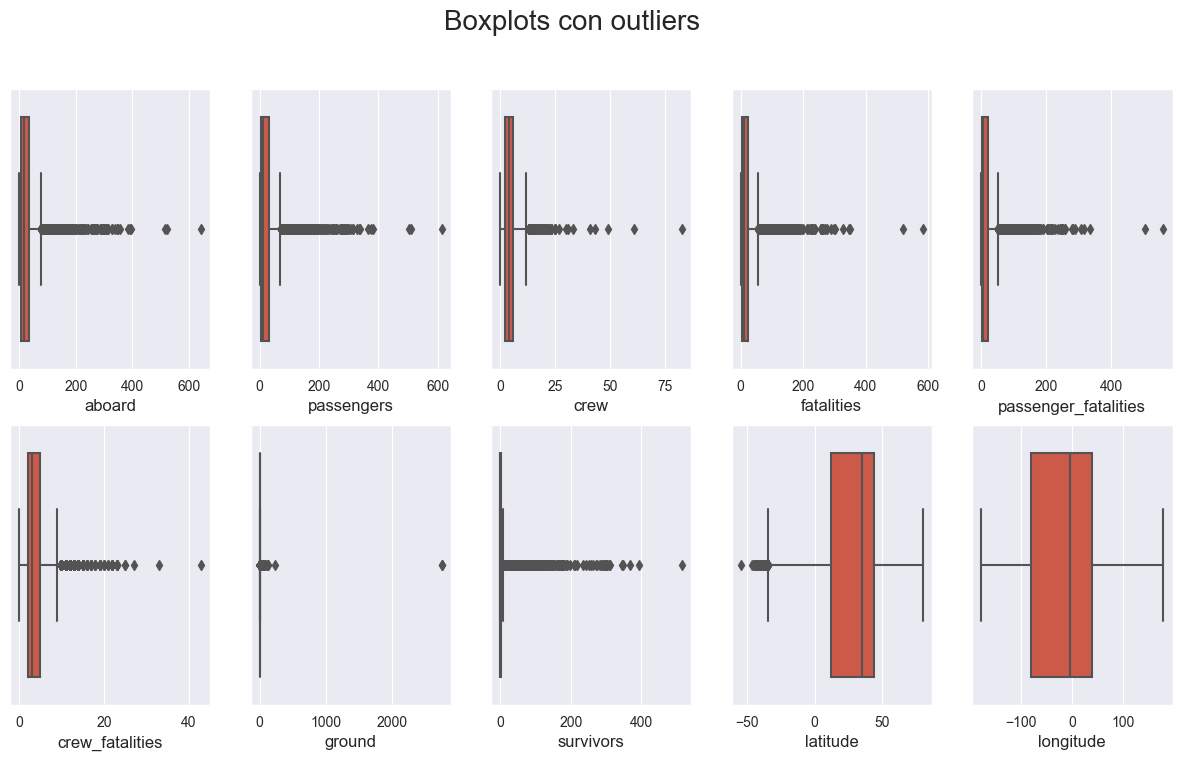

In [46]:
columns = ['aboard', 'passengers', 'crew', 'fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground', 'survivors', 'latitude', 'longitude']
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Boxplots con outliers', fontsize=20)
nvar=0

for ii in range(2):
    for jj in range(5):
        sns.boxplot(ax=axes[ii, jj], data=df, x=columns[nvar])
        nvar+=1

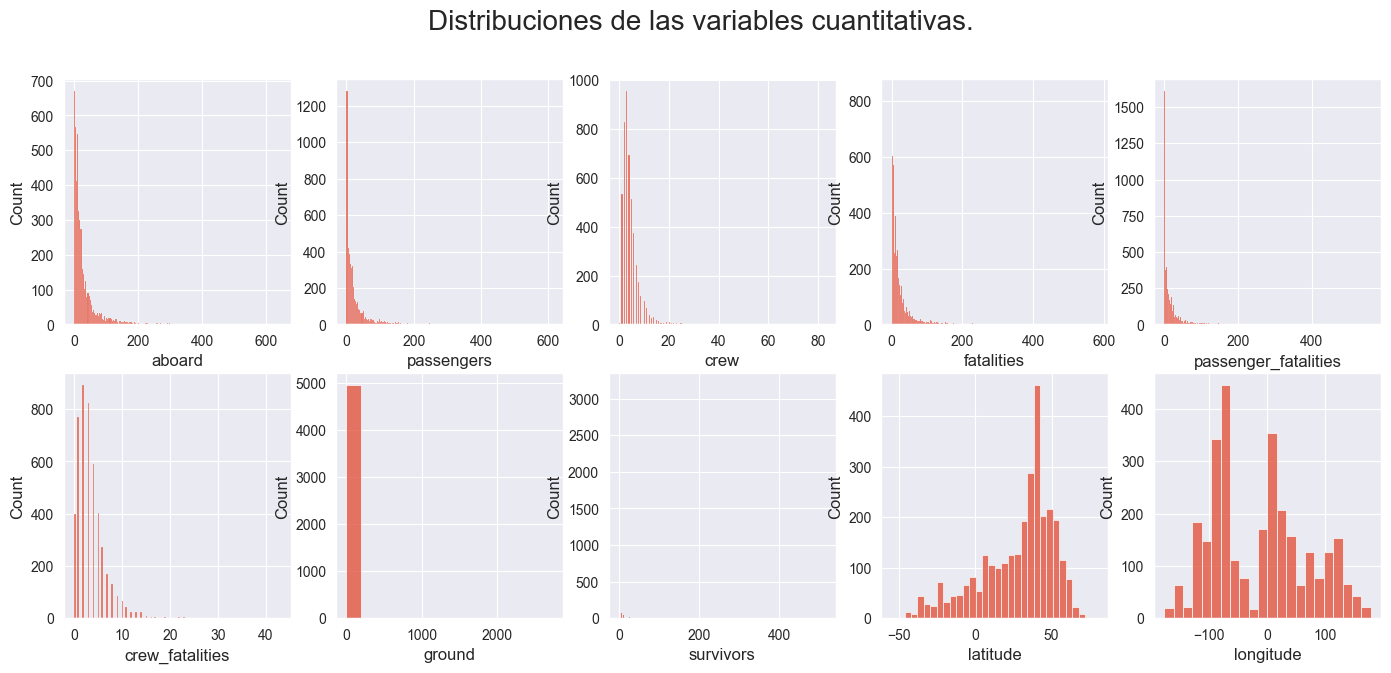

In [47]:
fig, axes = plt.subplots(2, 5, figsize=(17, 7))
fig.suptitle('Distribuciones de las variables cuantitativas.', fontsize=20)
nvar=0

for ii in range(2):
    for jj in range(5):
        sns.histplot(ax=axes[ii, jj], data=df, x=columns[nvar])
        nvar+=1

Vamos a utilizar la desviación estándar para hallar outliers en `fatalities` y `ground`

In [48]:
def find_outliers_std(df, column):
    '''
    Elimina outliers en una columna utilizando el IQR.
    '''

    # usamos el iqr
    std = df[column].std()
    mean = df[column].mean()

    # definimos los limites
    lower =  mean - 3*std
    upper = mean + 3*std

    #filtramos
    filter = ((df[column] >= lower) & (df[column] <= upper)) | (df[column].isnull())
    df = df.loc[filter]

    return df

In [49]:
columns_out = ['ground', 'fatalities']
df_out = df.copy()

for col in columns_out:
    df_out = find_outliers_std(df_out, col)

outliers = df[~df.index.isin(df_out.index)]
outliers.shape

(113, 35)

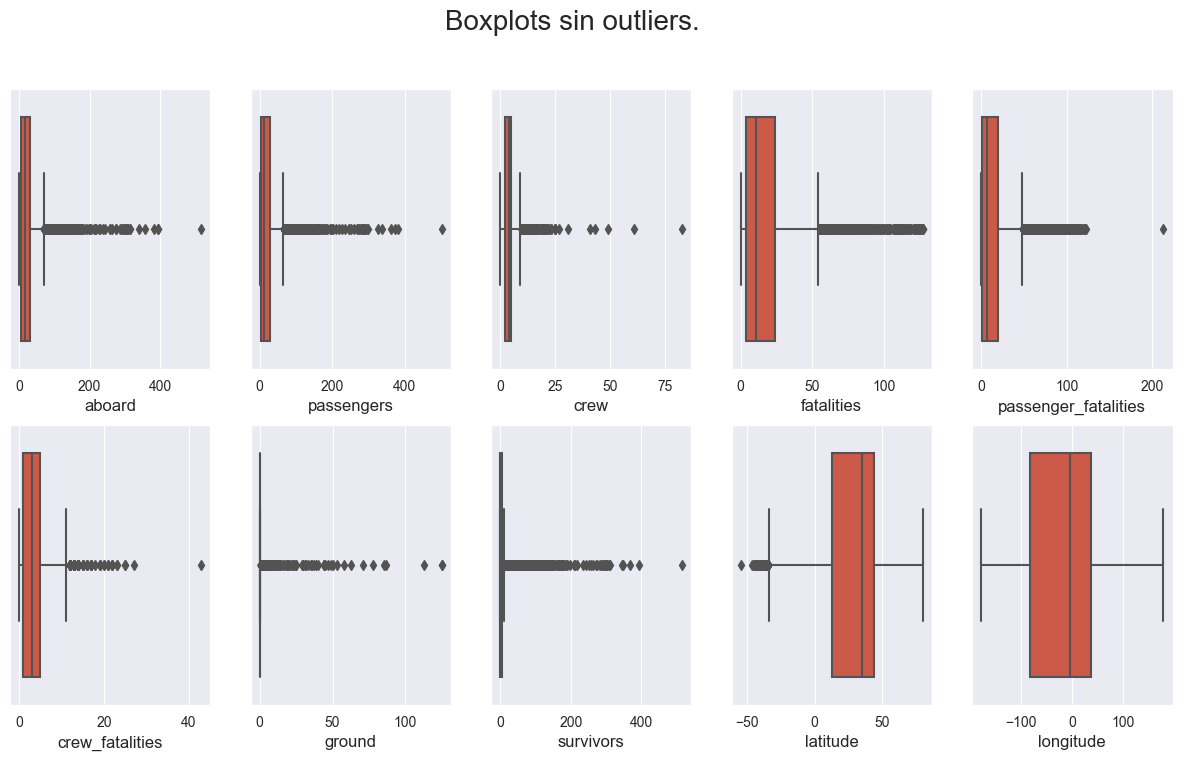

In [50]:
fig, axes = plt.subplots(2, 5, figsize=(15, 8))
fig.suptitle('Boxplots sin outliers.', fontsize=20)
nvar=0

for ii in range(2):
    for jj in range(5):
        sns.boxplot(ax=axes[ii, jj], data=df_out, x=columns[nvar])
        nvar+=1

## Limpieza final
Eliminamos las columnas que no vamos a utilizar en el análisis

In [51]:
df.isnull().sum()/df.shape[0]*100

id                       0.000000
date                     0.000000
time                     0.000000
location                 0.000000
operator                 0.000000
flight_no                0.000000
route                    0.000000
plane_type               0.000000
registration             0.000000
cn_ln                    0.000000
aboard                   0.339457
passengers               4.412939
crew                     4.373003
fatalities               0.159744
passenger_fatalities     4.692492
crew_fatalities          4.692492
ground                   0.878594
summary                  0.000000
crash_place              0.000000
survivors                0.339457
day_week                 0.000000
month_year               0.000000
temp_coor               40.275559
latitude                40.275559
longitude               40.275559
military                 0.000000
error_type              35.163738
key_word                35.163738
human_error              0.000000
landing       

In [52]:
df_reporte = df.copy()
df.drop(['id', 'flight_no', 'cn_ln', 'temp_coor', 'summary', 'latitude', 'longitude', 'location', 'error_type', 'key_word'], axis='columns', inplace=True)

In [53]:
# def fill_mode(df, column):
#     mode = df[column].mode()
#     df[column] = np.where(df[column].isnull(), mode, df[column])
#     return df

In [54]:
# columns = ['aboard', 'passengers', 'crew', 'fatalities', 'passenger_fatalities', 'crew_fatalities', 'ground', 'survivors']

# for col in columns:
#     df = fill_mode(df, col)

# df.isnull().sum()/df.shape[0]*100

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5008 entries, 0 to 5007
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   date                  5008 non-null   datetime64[ns]
 1   time                  5008 non-null   object        
 2   operator              5008 non-null   object        
 3   route                 5008 non-null   object        
 4   plane_type            5008 non-null   object        
 5   registration          5008 non-null   object        
 6   aboard                4991 non-null   float64       
 7   passengers            4787 non-null   float64       
 8   crew                  4789 non-null   float64       
 9   fatalities            5000 non-null   float64       
 10  passenger_fatalities  4773 non-null   float64       
 11  crew_fatalities       4773 non-null   float64       
 12  ground                4964 non-null   float64       
 13  crash_place       

In [56]:
df.columns

Index(['date', 'time', 'operator', 'route', 'plane_type', 'registration',
       'aboard', 'passengers', 'crew', 'fatalities', 'passenger_fatalities',
       'crew_fatalities', 'ground', 'crash_place', 'survivors', 'day_week',
       'month_year', 'military', 'human_error', 'landing', 'mechanical_issues',
       'takeoff', 'terrorism', 'water_crash', 'weather'],
      dtype='object')

In [57]:
# guardamos los datos
df.to_csv('dataset/plane_accidents.csv', index=False)
df_aviones.to_csv('dataset/departure_planes.csv', index=False)
df_passengers.to_csv('dataset/passengers_per_year.csv')
df_reporte.to_csv('dataset/datos_reporte.csv', index=False)